## Chapter 8: Integrating Learning and Planning

### Model-based Reinforcement Learning

In this chapter, we focus on RL algorithms that focus on learning **model** from experiences, and use it to construct value function or policy. 

RL algorithms that mentioned in previous chapters are **model-free RL**: it directly learns value function and(or) policy. 

And there exists **model-based RL**: it learns model from experience, and plan value function and(or) policy from model.

### What is a Model?

A *Model* $\mathcal{M}$ is a representation of an MDP <$\mathcal{S}, \mathcal{A}, \mathcal{P}, \mathcal{R}$> parametrized by $\eta$. Assuming we know state space $\mathcal{S}$ and action space $\mathcal{A}$, a model $<\mathcal{P}, \mathcal{R}>$ can represent transitions
</br>
</br>
<font size="3">
$$\begin{align}
S_{t+1} \sim \mathcal{P}_\eta(S_{t+1}|S_t, A_t) \\
R_{t+1} \sim \mathcal{R}_\eta(R_{t+1}|S_t, A_t)
\end{align}$$
</font>

model $<\mathcal{P}, \mathcal{R}>$ is learned from experience ${S_1, A_1, R_2, ... , S_T}$.

Model can be parametrized in various ways: from lookup table models to deep neural networks.

For example, lookup table models  can be constructed from experiences as the following:
</br>
</br>
<font size="3">
$$\begin{align}
\hat{\mathcal{P}}_{s, s'}^a = \dfrac{1}{N(s, a)} \sum_{t=1}^T \mathbb{1}(S_t, A_t, S_{t+1} = s, a, s') \\
\hat{\mathcal{R}}_{s}^a = \dfrac{1}{N(s, a)} \sum_{t=1}^T \mathbb{1}(S_t, A_t = s, a)R_t 
\end{align}$$
</font>

where $N(s, a)$ is a visit count to each state-action pair $(s,a)$.

If the model is accurate, then we can learn value function or policy from experiences sampled from the model. Yet if not, learning from simulated experience can lead to sub-optimal policy.

### Integrating Planning, Acting and Learning

Dyna-Q algorithm is a reinforcement learning algorithm that learns value function and(or) policy from both simulated experiences from **model** and **real-world experiences**. Dyna-Q uses real-world experiment to build model, and uses model to generate simulated experiences.

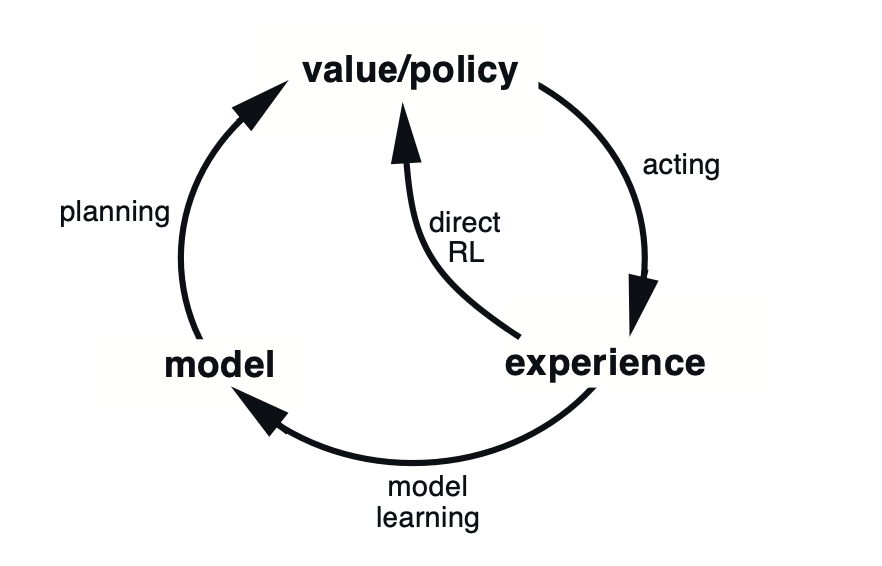 

Learning from both direct experiences and simulated experiences can help improving sample efficiency.


In [1]:
import gymnasium as gym
import matplotlib
import IPython
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
from utils import JupyterRender

%matplotlib inline

/opt/anaconda3/envs/rl/lib/python3.6/site-packages/gymnasium/core.py:27: UserWarning: WARN: Gymnasium minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+
  "Gymnasium minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+"


In [13]:
class Dyna_Q:
    def __init__(self, env, gamma=0.8, alpha=0.1, model_n=10, eps=0.1, render=False, max_episode=1000):
        self.env = env
        self.state_dim = env.observation_space.n
        self.action_dim = env.action_space.n
        
        self.gamma = gamma
        self.alpha = alpha
        self.model_n = model_n
        self.eps = eps
        self.max_episode = max_episode
        self.render = render
        
        self.q = np.zeros([self.state_dim, self.action_dim]) # q-value
        self.model_r = np.zeros([self.state_dim, self.action_dim]) # reward model
        self.model_ns = np.zeros([self.state_dim, self.action_dim]) # transition model
        
    def action(self, s):
        #epsilon-greedy action
        if np.random.random() < self.eps:
            action = np.random.randint(low=0, high=self.action_dim - 1)
        else:
            action = np.argmax(self.q[s,:])

        return action
    
    def run(self):
        states = []
        actions = []
        success = 0

        for episode in range(self.max_episode):
            observation, _ = self.env.reset()
            done = False
            episode_reward = 0
            local_step = 0
            
            while not done:
                action = self.action(observation)
                next_observation, reward, done, _, _ = self.env.step(action)
                
                # give penalty for staying in ground
                if reward == 0:
                    reward = -0.001
                # give penalty for falling into the hole
                if done and next_observation != 15:
                    reward = -1
                    
                episode_reward += reward
                local_step += 1
                
                # q-learning
                self.q[observation, action] = self.q[observation, action] + self.alpha*(reward + self.gamma*np.max(self.q[next_observation, :]) - self.q[observation, action])
                
                # model update
                self.model_r[observation, action] = reward
                self.model_ns[observation, action] = next_observation

                states.append(observation)
                actions.append(action)

                observation = next_observation
                
            # q-learning from samples generated in model
            for _ in range(self.model_n):
                sample = np.random.randint(low=0, high=len(states) - 1)
                s = states[sample]
                a = actions[sample]

                r = (self.model_r[s, a])
                ns = int(self.model_ns[s, a])
                self.q[s, a] = self.q[s,a] + self.alpha*(r + self.gamma*np.max(self.q[ns,:]) - self.q[s,a])

            print("Episode: {} -> Step: {}, Episode_reward: {}".format(episode, local_step, episode_reward))
            
            if episode_reward > 0:
                success += 1
                
        print("Success rate: ", success / self.max_episode)

    

In [14]:
env = gym.make("FrozenLake-v1", render_mode='rgb_array', is_slippery=False)#define the environment.
env = JupyterRender(env)

config = {
    'env': env,
    'gamma': 0.8,
    'alpha': 0.1,
    'model_n': 10,
    'eps': 0.1,
    'render': False,
    'max_episode': 1000
}

dyna_q = Dyna_Q(**config)
dyna_q.run()

Episode: 0 -> Step: 6, Episode_reward: -1.005
Episode: 1 -> Step: 5, Episode_reward: -1.004
Episode: 2 -> Step: 7, Episode_reward: -1.006
Episode: 3 -> Step: 7, Episode_reward: -1.006
Episode: 4 -> Step: 15, Episode_reward: -1.014
Episode: 5 -> Step: 5, Episode_reward: -1.004
Episode: 6 -> Step: 12, Episode_reward: -1.011
Episode: 7 -> Step: 13, Episode_reward: -1.012
Episode: 8 -> Step: 15, Episode_reward: 0.986
Episode: 9 -> Step: 14, Episode_reward: -1.013
Episode: 10 -> Step: 15, Episode_reward: -1.014
Episode: 11 -> Step: 8, Episode_reward: 0.993
Episode: 12 -> Step: 12, Episode_reward: -1.011
Episode: 13 -> Step: 18, Episode_reward: 0.983
Episode: 14 -> Step: 12, Episode_reward: 0.989
Episode: 15 -> Step: 6, Episode_reward: 0.995
Episode: 16 -> Step: 8, Episode_reward: 0.993
Episode: 17 -> Step: 8, Episode_reward: 0.993
Episode: 18 -> Step: 6, Episode_reward: 0.995
Episode: 19 -> Step: 5, Episode_reward: -1.004
Episode: 20 -> Step: 9, Episode_reward: 0.992
Episode: 21 -> Step: 6,

Episode: 749 -> Step: 6, Episode_reward: 0.995
Episode: 750 -> Step: 6, Episode_reward: 0.995
Episode: 751 -> Step: 7, Episode_reward: 0.994
Episode: 752 -> Step: 6, Episode_reward: 0.995
Episode: 753 -> Step: 6, Episode_reward: 0.995
Episode: 754 -> Step: 6, Episode_reward: 0.995
Episode: 755 -> Step: 6, Episode_reward: 0.995
Episode: 756 -> Step: 6, Episode_reward: 0.995
Episode: 757 -> Step: 6, Episode_reward: 0.995
Episode: 758 -> Step: 6, Episode_reward: 0.995
Episode: 759 -> Step: 6, Episode_reward: 0.995
Episode: 760 -> Step: 6, Episode_reward: 0.995
Episode: 761 -> Step: 6, Episode_reward: 0.995
Episode: 762 -> Step: 4, Episode_reward: -1.003
Episode: 763 -> Step: 6, Episode_reward: 0.995
Episode: 764 -> Step: 6, Episode_reward: 0.995
Episode: 765 -> Step: 4, Episode_reward: -1.003
Episode: 766 -> Step: 6, Episode_reward: 0.995
Episode: 767 -> Step: 11, Episode_reward: 0.99
Episode: 768 -> Step: 6, Episode_reward: 0.995
Episode: 769 -> Step: 6, Episode_reward: 0.995
Episode: 77

In [15]:
dyna_q.q

array([[ 0.25845105,  0.31954548,  0.3243184 ,  0.2575828 ],
       [ 0.25845043, -0.99998857,  0.406648  ,  0.3125919 ],
       [ 0.32431829,  0.50956   ,  0.3243125 ,  0.37510871],
       [ 0.40664776, -0.83322818,  0.27582193,  0.30995271],
       [ 0.27473856,  0.40421287, -0.90152291,  0.25840875],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.99999392,  0.6382    , -0.99973028,  0.26658092],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.18320945, -0.91137062,  0.50941359,  0.14855424],
       [ 0.19431484,  0.33005932,  0.63819988,  0.        ],
       [ 0.50946437,  0.799     , -0.99214483,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.83322818,  0.28750847,  0.79685095,  0.        ],
       [ 0.62622486,  0.79898483,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [16]:
dyna_q.model_ns

array([[ 0.,  4.,  1.,  0.],
       [ 0.,  5.,  2.,  1.],
       [ 1.,  6.,  3.,  2.],
       [ 2.,  7.,  3.,  3.],
       [ 4.,  8.,  5.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 5., 10.,  7.,  2.],
       [ 0.,  0.,  0.,  0.],
       [ 8., 12.,  9.,  4.],
       [ 8., 13., 10.,  0.],
       [ 9., 14., 11.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [12., 13., 14.,  0.],
       [13., 14., 15.,  0.],
       [ 0.,  0.,  0.,  0.]])

In [17]:
dyna_q.model_r

array([[-0.001, -0.001, -0.001, -0.001],
       [-0.001, -1.   , -0.001, -0.001],
       [-0.001, -0.001, -0.001, -0.001],
       [-0.001, -1.   , -0.001, -0.001],
       [-0.001, -0.001, -1.   , -0.001],
       [ 0.   ,  0.   ,  0.   ,  0.   ],
       [-1.   , -0.001, -1.   , -0.001],
       [ 0.   ,  0.   ,  0.   ,  0.   ],
       [-0.001, -1.   , -0.001, -0.001],
       [-0.001, -0.001, -0.001,  0.   ],
       [-0.001, -0.001, -1.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ],
       [-1.   , -0.001, -0.001,  0.   ],
       [-0.001, -0.001,  1.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ]])